In [ ]:
!pip install ultralytics

from IPython import display
display.clear_output()

In [ ]:
import yaml
from ultralytics import YOLO

import random
import cv2
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from pathlib import Path
import pathlib
%matplotlib inline
from collections import Counter

In [ ]:
import zipfile

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Load the YAML file
with open('/content/drive/MyDrive/ML in Medicine/Final/data.yaml', 'r') as f:
    data_yaml = yaml.safe_load(f)

# update YAML with absolute path to kaggle data. You must use absolute path, relative path won't work
data_yaml['train'] = '/content/drive/MyDrive/ML in Medicine/Final/train/images'
data_yaml['val'] = '/content/drive/MyDrive/ML in Medicine/Final/valid/images'

# write to disk
with open('data.yaml', 'w') as f:
    yaml.dump(data_yaml, f)

In [ ]:
data_yaml

{'train': '/content/drive/MyDrive/ML in Medicine/Final/train/images',
 'val': '/content/drive/MyDrive/ML in Medicine/Final/valid/images',
 'nc': 3,
 'names': ['Platelets', 'RBC', 'WBC']}

In [ ]:
data_dir = Path("/content/drive/MyDrive/ML in Medicine/Final")
images_dir = data_dir / "train" / "images"
labels_dir = data_dir / "train" / "labels"

class_names = data_yaml['names']

# Read the image file paths and annotations
image_paths = sorted(list(images_dir.glob("*.jpg"))) # images and paths must be sorted same way
label_paths = sorted(labels_dir.glob("*.txt"))

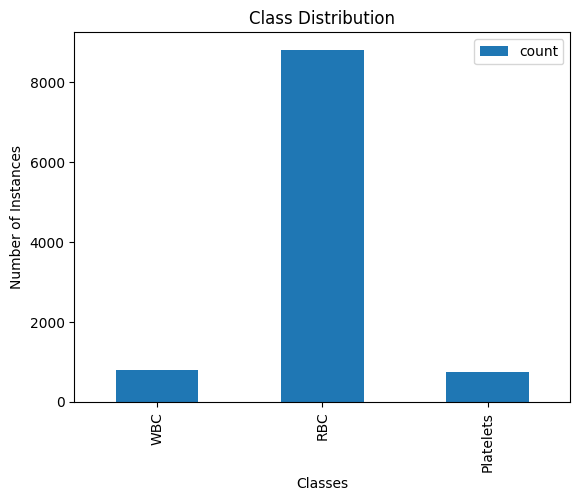

In [ ]:
class_counts = Counter()
for label_file in label_paths:
    with open(label_file, "r") as file:
        lines = file.readlines()
    class_counts.update(Counter([int(line.split()[0]) for line in lines]))

# Replace class IDs with class names
class_counts_names = {class_names[int(class_id)]: count for class_id, count in class_counts.items()}

# Create a pandas DataFrame and plot the bar chart
df = pd.DataFrame.from_dict(class_counts_names, orient="index", columns=["count"])
ax = df.plot(kind="bar")
plt.xlabel("Classes")
plt.ylabel("Number of Instances")
plt.title("Class Distribution")
plt.show()

In [ ]:
data = []

for file in label_paths:
    with open(file) as f:
        lines = f.readlines()
        num_lines = len(lines)
        unique_values = len(set(list(map(lambda x: x.split()[0], lines))))

        data.append([file, num_lines, unique_values])

df = pd.DataFrame(data, columns=['file', 'num_lines', 'unique_values'])

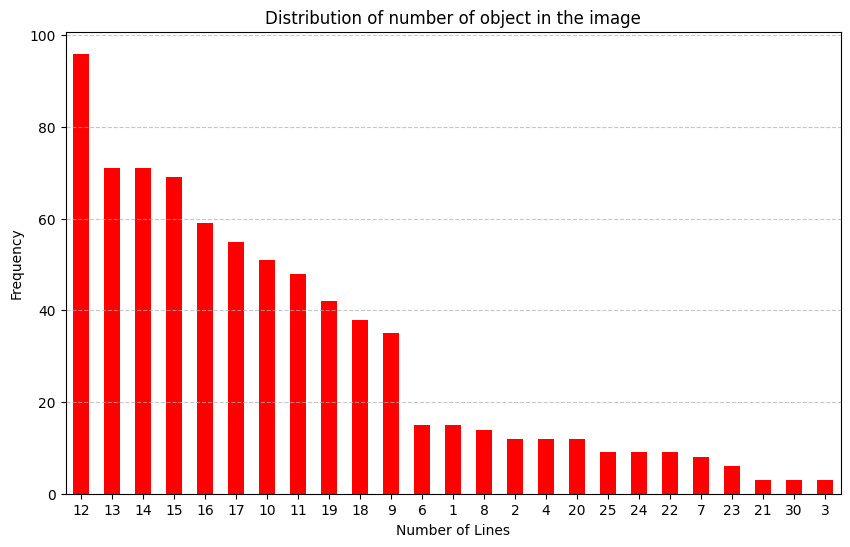

In [ ]:
# distribution of number of detections in an image
#df['num_lines'].value_counts().plot(kind='bar')
import matplotlib.pyplot as plt

# Get the value counts
num_lines_counts = df['num_lines'].value_counts()

# Create the bar plot
plt.figure(figsize=(10, 6))  # Set the figure size
num_lines_counts.plot(kind='bar', color='red')  # Set bar color

# Customize the plot
plt.xlabel('Number of Lines')
plt.ylabel('Frequency')
plt.title('Distribution of number of object in the image')
plt.xticks(rotation=0)  # Rotate x-axis labels for better readability
plt.grid(axis='y', linestyle='--', alpha=0.7)  # Add faint gridlines

# Display the plot
plt.show()


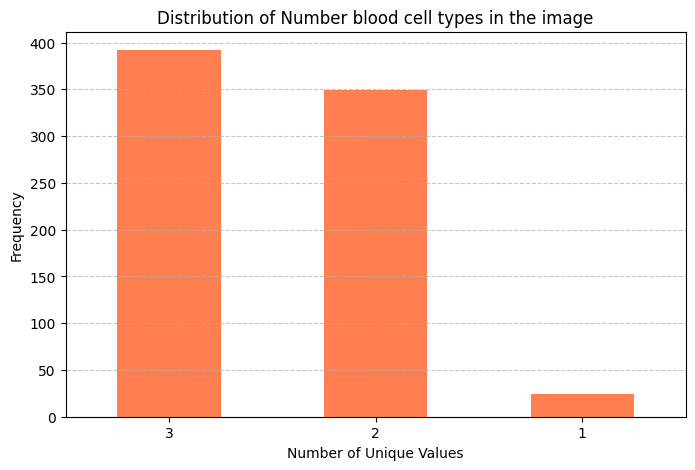

In [ ]:
#df['unique_values'].value_counts().plot(kind='bar')
unique_values_counts = df['unique_values'].value_counts()

# Create the bar plot
plt.figure(figsize=(8, 5))  # Set the figure size
unique_values_counts.plot(kind='bar', color='coral')  # Set bar color

# Customize the plot
plt.xlabel('Number of Unique Values')
plt.ylabel('Frequency')
plt.title('Distribution of Number blood cell types in the image')
plt.xticks(rotation=0)  # Rotate x-axis labels for better readability
plt.grid(axis='y', linestyle='--', alpha=0.7)  # Add faint gridlines

# Display the plot
plt.show()

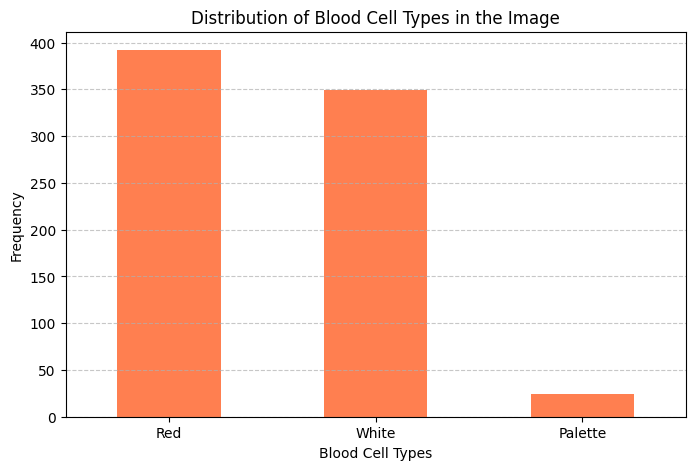

In [ ]:
import matplotlib.pyplot as plt

# Assuming you have the unique_values_counts already calculated
# unique_values_counts = df['unique_values'].value_counts()

# Set the names for each bar
blood_cell_types = ['Red', 'White', 'Palette']

# Create the bar plot
plt.figure(figsize=(8, 5))  # Set the figure size
unique_values_counts.plot(kind='bar', color='coral')  # Set bar color

# Customize the plot
plt.xlabel('Blood Cell Types')
plt.ylabel('Frequency')
plt.title('Distribution of Blood Cell Types in the Image')
plt.xticks(range(len(blood_cell_types)), blood_cell_types, rotation=0)  # Set custom x-axis labels
plt.grid(axis='y', linestyle='--', alpha=0.7)  # Add faint gridlines

# Display the plot
plt.show()


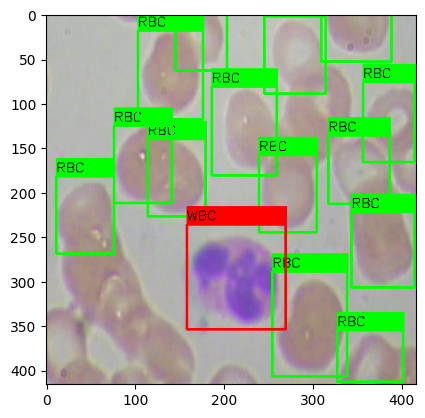

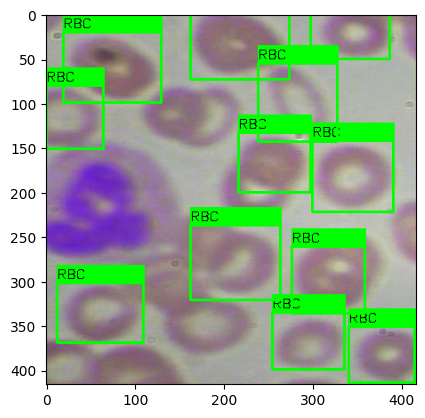

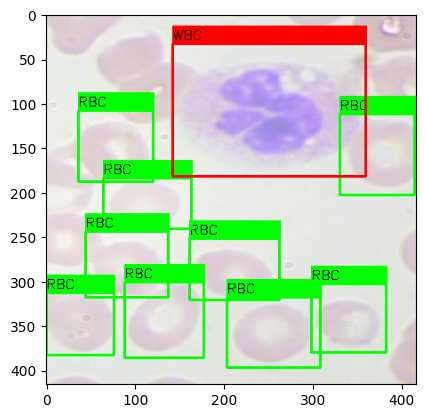

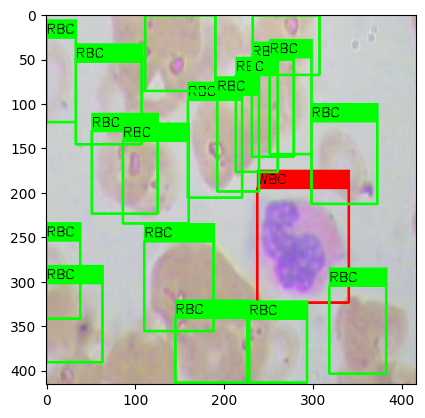

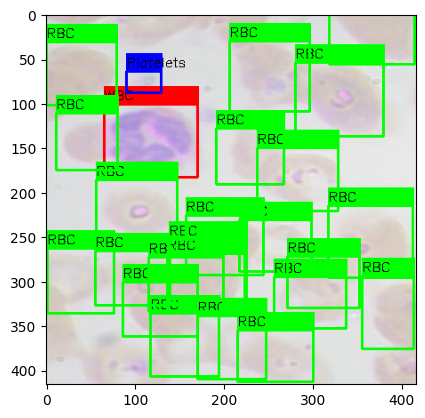

In [ ]:
num_images = 5

# Get the list of all image files in the 'images' directory
image_files = [f for f in pathlib.Path(images_dir).iterdir() if f.is_file()]

# Shuffle the list of image files
random.shuffle(image_files)

# Select the specified number of image files
selected_image_files = image_files[:num_images]

for selected_image_file in selected_image_files:
    demo_image = selected_image_file
    # Get the corresponding label file
    demo_label = pathlib.Path(labels_dir) / f"{selected_image_file.stem}.txt"

    # Load the image using OpenCV's imread function
    image = cv2.imread(str(demo_image))

    # Get the list of class names from the 'data' dictionary
    class_list = data_yaml['names']

    # Define a list of colors to be used to draw bounding boxes
    colors = [(255, 0, 0), (0, 255, 0), (0, 0, 255)]

    # Get the height and width of the image
    height, width, _ = image.shape

    # Create an empty list T
    T = []

    # Open the label file 'demo_label' in read mode and process each line
    with open(demo_label, "r") as file1:
        for line in file1.readlines():
            # Split the line into a list of strings
            split = line.split(" ")

            # Get the class id from the first element of the split list
            class_id = int(split[0])

            # Get the color corresponding to the class id from the 'colors' list
            color = colors[class_id]
            clazz = class_list[class_id]

            # Get the x, y, w, h bounding box coordinates from the split list
            x, y, w, h = float(split[1]), float(split[2]), float(split[3]), float(split[4])

            # Rescale the x, y, w, h values to the size of the image
            box = [int((x - 0.5*w)* width), int((y - 0.5*h) * height), int(w*width), int(h*height)]

            # Draw a rectangle on the image using the 'box' and 'color' values
            cv2.rectangle(image, box, color, 2)

            # Draw a filled rectangle for the class label on the image
            cv2.rectangle(image, (box[0], box[1] - 20), (box[0] + box[2], box[1]), color, -1)

            # Write the class label on the image
            cv2.putText(image, class_list[class_id], (box[0], box[1] - 5), cv2.FONT_HERSHEY_SIMPLEX, .5, (0,0,0))

        # Show the image using matplotlib
        plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
        # Optionally resize the image (commented out in code)
        image = cv2.resize(image, (600, 600))
        plt.show()

In [ ]:
baseline_model_1 = YOLO('yolov8x.yaml')

In [ ]:
params = {
    'data':'data.yaml',
    'imgsz':416,
    'epochs':100,
    'optimizer':'Adam',
    'pretrained':True,
    'lr0':0.01,
    'lrf': 0.00001,
    'cos_lr': True,
    'label_smoothing':0.15,
    'hsv_h' : 0.02,
    'hsv_s' : 0.50,
    'hsv_v' : 0.30,
    'degrees' : 5.0,
    'scale' : 0.3,
    'fliplr': 0.30,
    'mosaic': 0.50,
    'plots':True

}

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torch.utils.tensorboard import SummaryWriter

from torch.utils.data import Dataset

# Define model, dataset, loader, optimizer, and loss function
baseline_model = YOLO('yolov8x.yaml')

# Define data paths (modify as needed)
data_dir = Path("/content/drive/MyDrive/ML in Medicine/Final")
train_images = data_dir / "train/images"
train_labels = data_dir / "train/labels"
valid_images = data_dir / "valid/images"
valid_labels = data_dir / "valid/labels"

# Custom data loading function (replace with your implementation)
def load_data(image_path, label_path):
    # Your logic to load a single image and its corresponding label
    # This function should return a processed image tensor and label tensor
    image_tensor = ...
    label_tensor = ...
    return image_tensor, label_tensor

# Training and validation loop

baseline_model.train(**params)

# Save the trained model
torch.save(baseline_model.state_dict(), '/content/drive/MyDrive/ML in Medicine/Final/blood_cell_detection.pt')


Ultralytics YOLOv8.1.34 🚀 Python-3.10.12 torch-2.2.1+cu121 CUDA:0 (Tesla T4, 15102MiB)
engine/trainer: task=detect, mode=train, model=yolov8x.yaml, data=data.yaml, epochs=100, time=None, patience=100, batch=16, imgsz=416, save=True, save_period=-1, cache=False, device=None, workers=8, project=None, name=train, exist_ok=False, pretrained=True, optimizer=Adam, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=True, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.9, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, save_frames=False, save_txt=False, save_conf=False, save_crop=False, show_labels=True, show_conf=True, show_boxes=True, lin

100%|██████████| 755k/755k [00:00<00:00, 117MB/s]

Overriding model.yaml nc=80 with nc=3

                   from  n    params  module                                       arguments                     
  0                  -1  1      2320  ultralytics.nn.modules.conv.Conv             [3, 80, 3, 2]                 
  1                  -1  1    115520  ultralytics.nn.modules.conv.Conv             [80, 160, 3, 2]               
  2                  -1  3    436800  ultralytics.nn.modules.block.C2f             [160, 160, 3, True]           
  3                  -1  1    461440  ultralytics.nn.modules.conv.Conv             [160, 320, 3, 2]              
  4                  -1  6   3281920  ultralytics.nn.modules.block.C2f             [320, 320, 6, True]           
  5                  -1  1   1844480  ultralytics.nn.modules.conv.Conv             [320, 640, 3, 2]              
  6                  -1  6  13117440  ultralytics.nn.modules.block.C2f             [640, 640, 6, True]           
  7                  -1  1   3687680  ultralytics

  8                  -1  3   6969600  ultralytics.nn.modules.block.C2f             [640, 640, 3, True]           
  9                  -1  1   1025920  ultralytics.nn.modules.block.SPPF            [640, 640, 5]                 
 10                  -1  1         0  torch.nn.modules.upsampling.Upsample         [None, 2, 'nearest']          
 11             [-1, 6]  1         0  ultralytics.nn.modules.conv.Concat           [1]                           
 12                  -1  3   7379200  ultralytics.nn.modules.block.C2f             [1280, 640, 3]                
 13                  -1  1         0  torch.nn.modules.upsampling.Upsample         [None, 2, 'nearest']          
 14             [-1, 4]  1         0  ultralytics.nn.modules.conv.Concat           [1]                           
 15                  -1  3   1948800  ultralytics.nn.modules.block.C2f             [960, 320, 3]                 
 16                  -1  1    922240  ultralytics.nn.modules.conv.Conv             [320,

100%|██████████| 6.23M/6.23M [00:00<00:00, 161MB/s]


AMP: checks passed ✅


train: Scanning /content/drive/.shortcut-targets-by-id/1oMS2FmTrMcjmjluSoEebjL_JZkk1BodF/ML in Medicine/Final/train/labels... 765 images, 0 backgrounds, 0 corrupt: 100%|██████████| 765/765 [11:14<00:00,  1.13it/s]


train: New cache created: /content/drive/.shortcut-targets-by-id/1oMS2FmTrMcjmjluSoEebjL_JZkk1BodF/ML in Medicine/Final/train/labels.cache
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01), CLAHE(p=0.01, clip_limit=(1, 4.0), tile_grid_size=(8, 8))


val: Scanning /content/drive/.shortcut-targets-by-id/1oMS2FmTrMcjmjluSoEebjL_JZkk1BodF/ML in Medicine/Final/valid/labels... 73 images, 0 backgrounds, 0 corrupt: 100%|██████████| 73/73 [02:00<00:00,  1.65s/it]

val: New cache created: /content/drive/.shortcut-targets-by-id/1oMS2FmTrMcjmjluSoEebjL_JZkk1BodF/ML in Medicine/Final/valid/labels.cache


Plotting labels to runs/detect/train/labels.jpg... 
optimizer: Adam(lr=0.01, momentum=0.937) with parameter groups 97 weight(decay=0.0), 104 weight(decay=0.0005), 103 bias(decay=0.0)
TensorBoard: model graph visualization added ✅
Image sizes 416 train, 416 val
Using 2 dataloader workers
Logging results to runs/detect/train
Starting training for 100 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      1/100      7.16G      3.118       2.65       3.25        208        416: 100%|██████████| 48/48 [00:35<00:00,  1.37it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  1.94it/s]

                   all         73        967          0          0          0          0



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      2/100      7.53G      2.541      2.136      2.607        239        416: 100%|██████████| 48/48 [00:28<00:00,  1.67it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:02<00:00,  1.08it/s]


                   all         73        967    0.00163      0.306    0.00163   0.000895

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      3/100      6.69G      2.258       2.02       2.45        182        416: 100%|██████████| 48/48 [00:28<00:00,  1.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.52it/s]


                   all         73        967      0.158      0.359       0.07     0.0183

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      4/100      6.68G      2.176      1.957      2.385        255        416: 100%|██████████| 48/48 [00:27<00:00,  1.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.38it/s]

                   all         73        967      0.419      0.427     0.0849     0.0366



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      5/100       6.7G       1.94      1.749      2.208        252        416: 100%|██████████| 48/48 [00:27<00:00,  1.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.59it/s]


                   all         73        967      0.022     0.0885     0.0113    0.00372

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      6/100      6.69G      1.824      1.649      2.101        250        416: 100%|██████████| 48/48 [00:27<00:00,  1.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.14it/s]

                   all         73        967      0.708     0.0556     0.0333     0.0143



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      7/100      6.69G      1.707      1.517      2.023        254        416: 100%|██████████| 48/48 [00:27<00:00,  1.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.56it/s]


                   all         73        967       0.48       0.25      0.191     0.0625

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      8/100       6.7G      1.648      1.419       1.95        273        416: 100%|██████████| 48/48 [00:28<00:00,  1.69it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.05it/s]

                   all         73        967      0.375      0.585      0.441      0.228



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      9/100      6.67G      1.584      1.347      1.909        213        416: 100%|██████████| 48/48 [00:27<00:00,  1.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.59it/s]


                   all         73        967      0.204      0.508      0.162       0.06

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     10/100      6.68G      1.604      1.332      1.925        235        416: 100%|██████████| 48/48 [00:27<00:00,  1.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.46it/s]


                   all         73        967      0.245      0.299      0.255      0.131

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     11/100       6.7G      1.558      1.267      1.884        162        416: 100%|██████████| 48/48 [00:27<00:00,  1.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.36it/s]

                   all         73        967      0.826      0.171      0.173     0.0905



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     12/100      6.68G      1.551      1.276      1.881        185        416: 100%|██████████| 48/48 [00:28<00:00,  1.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.48it/s]


                   all         73        967      0.466      0.513      0.442      0.225

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     13/100       6.7G      1.546      1.275      1.866        205        416: 100%|██████████| 48/48 [00:27<00:00,  1.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.72it/s]

                   all         73        967      0.466      0.513      0.442      0.225



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     14/100      6.69G      1.477      1.212      1.811        201        416: 100%|██████████| 48/48 [00:27<00:00,  1.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  1.95it/s]

                   all         73        967      0.544       0.16      0.139     0.0537



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     15/100      6.71G      1.452      1.197      1.793        230        416: 100%|██████████| 48/48 [00:27<00:00,  1.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.51it/s]


                   all         73        967      0.449      0.604      0.566       0.34

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     16/100      6.67G      1.449       1.17      1.785        199        416: 100%|██████████| 48/48 [00:27<00:00,  1.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.55it/s]


                   all         73        967      0.567      0.621      0.607      0.345

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     17/100      6.67G      1.449      1.149      1.772        187        416: 100%|██████████| 48/48 [00:28<00:00,  1.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.53it/s]

                   all         73        967      0.546      0.637      0.611      0.283



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     18/100       6.7G      1.457      1.155      1.773        185        416: 100%|██████████| 48/48 [00:27<00:00,  1.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.51it/s]


                   all         73        967      0.564      0.595      0.594      0.333

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     19/100       6.7G      1.431      1.135      1.764        214        416: 100%|██████████| 48/48 [00:27<00:00,  1.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.56it/s]


                   all         73        967      0.619      0.589      0.592      0.336

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     20/100      6.66G      1.406      1.135      1.747        205        416: 100%|██████████| 48/48 [00:27<00:00,  1.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.54it/s]


                   all         73        967      0.475      0.671      0.639      0.402

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     21/100      6.69G      1.393      1.071      1.721        194        416: 100%|██████████| 48/48 [00:27<00:00,  1.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.47it/s]


                   all         73        967      0.632      0.594       0.67      0.423

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     22/100      6.68G      1.419      1.109      1.744        228        416: 100%|██████████| 48/48 [00:27<00:00,  1.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.50it/s]

                   all         73        967      0.388      0.597      0.519      0.277



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     23/100      6.73G      1.406      1.098      1.738        195        416: 100%|██████████| 48/48 [00:27<00:00,  1.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.58it/s]


                   all         73        967      0.435      0.753      0.643      0.364

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     24/100      6.66G      1.367      1.043      1.712        190        416: 100%|██████████| 48/48 [00:27<00:00,  1.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.00it/s]

                   all         73        967      0.428      0.614       0.57      0.328



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     25/100      6.71G      1.348      1.042      1.692        185        416: 100%|██████████| 48/48 [00:27<00:00,  1.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.62it/s]

                   all         73        967      0.403      0.755      0.651      0.371



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     26/100      6.67G      1.356      1.021      1.699        188        416: 100%|██████████| 48/48 [00:27<00:00,  1.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.32it/s]

                   all         73        967      0.505      0.384      0.363      0.198



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     27/100      6.68G      1.343      1.017      1.697        218        416: 100%|██████████| 48/48 [00:27<00:00,  1.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.58it/s]


                   all         73        967      0.579      0.547       0.61      0.307

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     28/100      6.71G      1.354      1.029      1.693        203        416: 100%|██████████| 48/48 [00:27<00:00,  1.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.40it/s]

                   all         73        967      0.331      0.637      0.489      0.226



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     29/100      6.68G      1.336          1      1.679        224        416: 100%|██████████| 48/48 [00:28<00:00,  1.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.11it/s]

                   all         73        967      0.697      0.578      0.728      0.475



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     30/100      6.66G      1.335     0.9777      1.671        210        416: 100%|██████████| 48/48 [00:27<00:00,  1.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.59it/s]


                   all         73        967      0.517      0.763      0.691      0.452

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     31/100       6.7G      1.325     0.9878      1.677        212        416: 100%|██████████| 48/48 [00:27<00:00,  1.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.51it/s]

                   all         73        967      0.584      0.664       0.68      0.385



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     32/100      6.71G      1.291     0.9711      1.654        195        416: 100%|██████████| 48/48 [00:27<00:00,  1.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.48it/s]

                   all         73        967      0.537      0.746      0.752      0.474



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     33/100      6.72G       1.31     0.9645      1.654        203        416: 100%|██████████| 48/48 [00:27<00:00,  1.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.31it/s]


                   all         73        967      0.476      0.607      0.605      0.362

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     34/100      6.68G      1.314     0.9924      1.647        243        416: 100%|██████████| 48/48 [00:27<00:00,  1.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.57it/s]


                   all         73        967      0.672      0.715       0.75      0.419

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     35/100      6.71G      1.294     0.9703      1.649        227        416: 100%|██████████| 48/48 [00:27<00:00,  1.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.25it/s]

                   all         73        967      0.527      0.751      0.712      0.467



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     36/100      6.71G       1.27     0.9665      1.623        216        416: 100%|██████████| 48/48 [00:27<00:00,  1.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.54it/s]


                   all         73        967        0.5      0.763      0.707      0.447

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     37/100      6.71G      1.262     0.9498      1.613        233        416: 100%|██████████| 48/48 [00:27<00:00,  1.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.57it/s]


                   all         73        967       0.56      0.726       0.71      0.463

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     38/100      6.66G      1.257      0.932      1.618        182        416: 100%|██████████| 48/48 [00:27<00:00,  1.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.55it/s]


                   all         73        967      0.558      0.671      0.697      0.423

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     39/100       6.7G       1.28     0.9554       1.63        178        416: 100%|██████████| 48/48 [00:27<00:00,  1.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.20it/s]

                   all         73        967      0.557      0.657      0.657      0.428



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     40/100      6.71G      1.264     0.9284      1.609        221        416: 100%|██████████| 48/48 [00:27<00:00,  1.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.58it/s]

                   all         73        967      0.469      0.686      0.638      0.384



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     41/100      6.66G      1.254     0.9175      1.604        221        416: 100%|██████████| 48/48 [00:28<00:00,  1.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.50it/s]

                   all         73        967      0.623      0.683      0.714      0.474



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     42/100      6.67G      1.243      0.919      1.601        221        416: 100%|██████████| 48/48 [00:27<00:00,  1.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.52it/s]


                   all         73        967      0.675      0.661      0.769      0.491

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     43/100       6.7G      1.244     0.8962      1.591        212        416: 100%|██████████| 48/48 [00:28<00:00,  1.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.25it/s]


                   all         73        967      0.636      0.784      0.776      0.485

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     44/100      6.67G      1.227     0.9086      1.592        206        416: 100%|██████████| 48/48 [00:27<00:00,  1.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.54it/s]


                   all         73        967      0.481      0.703      0.602      0.339

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     45/100      6.66G       1.23     0.9015       1.59        179        416: 100%|██████████| 48/48 [00:27<00:00,  1.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.48it/s]

                   all         73        967       0.62      0.697      0.723      0.461



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     46/100      6.68G      1.241     0.9003      1.602        191        416: 100%|██████████| 48/48 [00:27<00:00,  1.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.59it/s]


                   all         73        967      0.677      0.746      0.753      0.482

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     47/100      6.72G      1.227     0.9024      1.598        219        416: 100%|██████████| 48/48 [00:28<00:00,  1.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.55it/s]


                   all         73        967      0.611      0.765      0.725      0.487

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     48/100       6.7G      1.223     0.8888      1.583        195        416: 100%|██████████| 48/48 [00:27<00:00,  1.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.17it/s]

                   all         73        967      0.521      0.802      0.722       0.49



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     49/100       6.7G      1.236     0.8974      1.591        194        416: 100%|██████████| 48/48 [00:27<00:00,  1.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.57it/s]


                   all         73        967      0.594      0.795      0.763      0.473

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     50/100      6.68G      1.204     0.8732      1.561        195        416: 100%|██████████| 48/48 [00:27<00:00,  1.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.22it/s]


                   all         73        967      0.587      0.739      0.738      0.478

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     51/100       6.7G      1.191      0.858      1.543        227        416: 100%|██████████| 48/48 [00:27<00:00,  1.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.61it/s]


                   all         73        967      0.629      0.784      0.784      0.489

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     52/100      6.66G      1.188     0.8513      1.561        188        416: 100%|██████████| 48/48 [00:27<00:00,  1.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.56it/s]


                   all         73        967       0.54      0.779      0.728      0.465

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     53/100      6.71G      1.188      0.855      1.551        182        416: 100%|██████████| 48/48 [00:27<00:00,  1.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.57it/s]


                   all         73        967      0.605      0.802       0.75      0.496

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     54/100       6.7G      1.184     0.8505      1.559        209        416: 100%|██████████| 48/48 [00:28<00:00,  1.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.51it/s]


                   all         73        967      0.597      0.803      0.727      0.469

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     55/100      6.67G      1.209     0.8697      1.558        266        416: 100%|██████████| 48/48 [00:27<00:00,  1.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.42it/s]

                   all         73        967      0.569      0.776      0.724      0.456



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     56/100      6.69G      1.198     0.8705      1.563        201        416: 100%|██████████| 48/48 [00:27<00:00,  1.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.50it/s]


                   all         73        967      0.647      0.713      0.748      0.509

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     57/100       6.7G      1.174     0.8437      1.553        197        416: 100%|██████████| 48/48 [00:27<00:00,  1.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.55it/s]


                   all         73        967      0.666      0.744      0.776      0.519

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     58/100      6.69G      1.177     0.8396      1.541        194        416: 100%|██████████| 48/48 [00:27<00:00,  1.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.53it/s]


                   all         73        967      0.626      0.753      0.771      0.495

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     59/100      6.68G      1.165     0.8335      1.526        175        416: 100%|██████████| 48/48 [00:27<00:00,  1.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.58it/s]


                   all         73        967      0.534      0.778      0.729      0.469

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     60/100      6.67G      1.174      0.835      1.539        217        416: 100%|██████████| 48/48 [00:27<00:00,  1.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.60it/s]


                   all         73        967       0.67      0.777      0.793      0.546

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     61/100       6.7G      1.169     0.8285      1.533        216        416: 100%|██████████| 48/48 [00:27<00:00,  1.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.52it/s]


                   all         73        967      0.679      0.834      0.822      0.565

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     62/100       6.7G      1.169     0.8324      1.525        262        416: 100%|██████████| 48/48 [00:27<00:00,  1.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.53it/s]

                   all         73        967      0.701      0.736      0.788      0.521



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     63/100      6.66G      1.152     0.8099      1.521        260        416: 100%|██████████| 48/48 [00:27<00:00,  1.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.64it/s]

                   all         73        967      0.725       0.79      0.821      0.531



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     64/100      6.68G      1.153     0.8248      1.527        210        416: 100%|██████████| 48/48 [00:27<00:00,  1.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.59it/s]


                   all         73        967       0.65      0.814      0.821      0.539

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     65/100      6.66G      1.159     0.8225      1.528        228        416: 100%|██████████| 48/48 [00:27<00:00,  1.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.50it/s]


                   all         73        967      0.653       0.82      0.829       0.57

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     66/100      6.67G      1.148     0.8203      1.523        276        416: 100%|██████████| 48/48 [00:27<00:00,  1.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.26it/s]


                   all         73        967      0.651      0.742      0.803      0.511

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     67/100      6.71G      1.142     0.8055      1.513        237        416: 100%|██████████| 48/48 [00:27<00:00,  1.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.62it/s]


                   all         73        967      0.711      0.748      0.824      0.565

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     68/100      6.71G      1.132     0.7972       1.51        208        416: 100%|██████████| 48/48 [00:27<00:00,  1.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.30it/s]


                   all         73        967      0.661      0.792      0.809      0.565

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     69/100      6.69G      1.124     0.7973      1.497        209        416: 100%|██████████| 48/48 [00:27<00:00,  1.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.60it/s]


                   all         73        967      0.732      0.723      0.814      0.528

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     70/100      6.69G      1.109     0.7764      1.492        194        416: 100%|██████████| 48/48 [00:27<00:00,  1.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.52it/s]


                   all         73        967      0.608      0.808      0.783      0.536

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     71/100      6.66G      1.127      0.784      1.496        222        416: 100%|██████████| 48/48 [00:27<00:00,  1.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.58it/s]


                   all         73        967      0.698      0.845      0.847      0.566

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     72/100      6.68G      1.128     0.8005      1.504        167        416: 100%|██████████| 48/48 [00:27<00:00,  1.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.56it/s]


                   all         73        967       0.65      0.763      0.789      0.519

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     73/100      6.68G      1.121     0.7837      1.496        241        416: 100%|██████████| 48/48 [00:28<00:00,  1.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.30it/s]

                   all         73        967      0.719      0.811      0.829      0.528



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     74/100      6.69G      1.105     0.7746      1.476        255        416: 100%|██████████| 48/48 [00:27<00:00,  1.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.57it/s]


                   all         73        967      0.671      0.852      0.835      0.569

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     75/100      6.66G      1.106     0.7739      1.488        160        416: 100%|██████████| 48/48 [00:27<00:00,  1.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.12it/s]


                   all         73        967      0.737      0.749      0.837      0.565

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     76/100      6.66G      1.114     0.7837      1.489        179        416: 100%|██████████| 48/48 [00:27<00:00,  1.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.57it/s]


                   all         73        967      0.695      0.841      0.836      0.541

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     77/100      6.71G      1.101     0.7851      1.483        169        416: 100%|██████████| 48/48 [00:27<00:00,  1.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.59it/s]


                   all         73        967      0.676      0.778      0.822      0.566

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     78/100       6.7G      1.091     0.7739      1.475        232        416: 100%|██████████| 48/48 [00:27<00:00,  1.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.56it/s]


                   all         73        967      0.721      0.824      0.833      0.571

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     79/100      6.67G      1.088     0.7554      1.471        228        416: 100%|██████████| 48/48 [00:28<00:00,  1.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.56it/s]


                   all         73        967      0.773      0.814      0.845      0.592

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     80/100      6.68G      1.086     0.7639      1.465        233        416: 100%|██████████| 48/48 [00:27<00:00,  1.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.18it/s]

                   all         73        967      0.746      0.827      0.834      0.586



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     81/100      6.69G      1.087     0.7527       1.47        231        416: 100%|██████████| 48/48 [00:27<00:00,  1.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.58it/s]


                   all         73        967      0.722      0.847      0.838      0.582

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     82/100       6.7G      1.076     0.7515      1.453        176        416: 100%|██████████| 48/48 [00:27<00:00,  1.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  1.97it/s]

                   all         73        967      0.733      0.818      0.872       0.61



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     83/100      6.67G      1.068     0.7444      1.452        218        416: 100%|██████████| 48/48 [00:28<00:00,  1.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.33it/s]

                   all         73        967       0.76      0.828      0.869      0.605



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     84/100      6.66G      1.055     0.7396      1.445        152        416: 100%|██████████| 48/48 [00:27<00:00,  1.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.52it/s]

                   all         73        967      0.759       0.82      0.844      0.586



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     85/100       6.7G      1.069       0.75      1.467        221        416: 100%|██████████| 48/48 [00:28<00:00,  1.70it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.50it/s]


                   all         73        967      0.765      0.828      0.838        0.6

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     86/100      6.71G      1.061     0.7378      1.448        212        416: 100%|██████████| 48/48 [00:27<00:00,  1.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.21it/s]

                   all         73        967      0.807      0.823      0.869      0.619



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     87/100      6.66G      1.046     0.7195      1.431        189        416: 100%|██████████| 48/48 [00:27<00:00,  1.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.24it/s]


                   all         73        967      0.727      0.829      0.863      0.609

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     88/100      6.69G      1.051     0.7311      1.441        226        416: 100%|██████████| 48/48 [00:27<00:00,  1.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.60it/s]


                   all         73        967      0.794      0.807      0.862      0.611

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     89/100      6.66G      1.048     0.7333      1.439        194        416: 100%|██████████| 48/48 [00:27<00:00,  1.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.54it/s]

                   all         73        967      0.712      0.839      0.834      0.583



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     90/100      6.67G      1.056     0.7309      1.446        210        416: 100%|██████████| 48/48 [00:28<00:00,  1.70it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.12it/s]

                   all         73        967      0.776      0.807      0.848      0.599


Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01), CLAHE(p=0.01, clip_limit=(1, 4.0), tile_grid_size=(8, 8))

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     91/100      6.67G      1.028     0.7035      1.445        210        416: 100%|██████████| 48/48 [00:32<00:00,  1.50it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.57it/s]


                   all         73        967      0.765      0.804      0.881      0.625

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     92/100      6.67G      1.009     0.6846      1.427        163        416: 100%|██████████| 48/48 [00:27<00:00,  1.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.56it/s]


                   all         73        967      0.787      0.833      0.875      0.618

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     93/100      6.67G      1.009     0.6812      1.438        168        416: 100%|██████████| 48/48 [00:27<00:00,  1.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  1.99it/s]

                   all         73        967      0.777      0.818      0.869      0.623



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     94/100      6.69G      1.015     0.6848      1.449        173        416: 100%|██████████| 48/48 [00:27<00:00,  1.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.54it/s]


                   all         73        967      0.754      0.851      0.864      0.615

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     95/100      6.67G      1.002     0.6802      1.426        177        416: 100%|██████████| 48/48 [00:28<00:00,  1.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.34it/s]

                   all         73        967      0.769      0.807      0.868      0.624



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     96/100      6.66G      1.006     0.6772      1.425        152        416: 100%|██████████| 48/48 [00:27<00:00,  1.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.19it/s]

                   all         73        967      0.785      0.828       0.88      0.631



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     97/100      6.68G      0.997     0.6737      1.413        155        416: 100%|██████████| 48/48 [00:28<00:00,  1.70it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.55it/s]


                   all         73        967      0.776      0.848      0.882      0.633

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     98/100      6.67G      1.003     0.6727      1.428        183        416: 100%|██████████| 48/48 [00:27<00:00,  1.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.50it/s]

                   all         73        967      0.769      0.854      0.874      0.629



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     99/100      6.67G          1      0.677      1.432        182        416: 100%|██████████| 48/48 [00:27<00:00,  1.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.20it/s]

                   all         73        967      0.805      0.819      0.877      0.629



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    100/100      6.67G      1.005     0.6807      1.431        198        416: 100%|██████████| 48/48 [00:27<00:00,  1.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.62it/s]

                   all         73        967      0.775      0.853      0.874      0.628



100 epochs completed in 1.010 hours.
Optimizer stripped from runs/detect/train/weights/last.pt, 136.7MB
Optimizer stripped from runs/detect/train/weights/best.pt, 136.7MB

Validating runs/detect/train/weights/best.pt...
Ultralytics YOLOv8.1.34 🚀 Python-3.10.12 torch-2.2.1+cu121 CUDA:0 (Tesla T4, 15102MiB)
YOLOv8x summary (fused): 268 layers, 68126457 parameters, 0 gradients, 257.4 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:05<00:00,  1.86s/it]


                   all         73        967      0.776       0.85      0.879      0.631
             Platelets         73         76      0.596      0.829      0.797      0.478
                   RBC         73        819      0.809       0.72      0.856      0.617
                   WBC         73         72      0.922          1      0.982      0.799
Speed: 0.4ms preprocess, 13.8ms inference, 0.0ms loss, 3.4ms postprocess per image
Results saved to runs/detect/train


In [ ]:

post_training_files_path = '/content/runs/detect/train'

In [ ]:
with zipfile.ZipFile('post_training_files.zip', 'w') as zip_ref:
    zip_ref.write('/content/runs/detect/train', arcname='train')

In [ ]:
from google.colab import files
files.download("/content/post_training_files.zip")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
def plot_learning_curve(df, train_loss_col, val_loss_col, title):
    plt.figure(figsize=(12, 5))
    sns.lineplot(data=df, x='epoch', y=train_loss_col, label='Train Loss', color='#141140', linestyle='-', linewidth=2)
    sns.lineplot(data=df, x='epoch', y=val_loss_col, label='Validation Loss', color='orangered', linestyle='--', linewidth=2)
    plt.title(title)
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

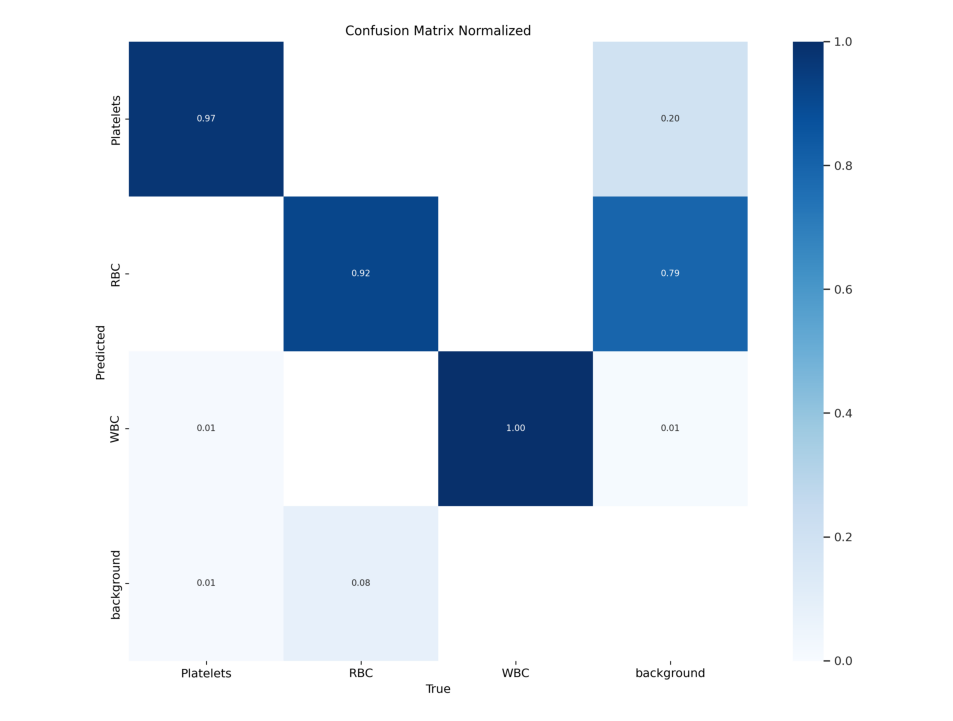

In [ ]:
confusion_matrix_path = os.path.join(post_training_files_path, 'confusion_matrix_normalized.png')

# Read the image using cv2
cm_img = cv2.imread(confusion_matrix_path)

# Convert the image from BGR to RGB color space for accurate color representation with matplotlib
cm_img = cv2.cvtColor(cm_img, cv2.COLOR_BGR2RGB)

# Display the image
plt.figure(figsize=(10, 10), dpi=120)
plt.imshow(cm_img)
plt.axis('off')
plt.show()


In [ ]:
best_model_path = os.path.join(post_training_files_path, 'weights/best.pt')

# Load the best model weights into the YOLO model
best_model = YOLO(best_model_path)

# Validate the best model using the validation set with default parameters
metrics = best_model.val(split='val')

KeyError: 'model'

In [ ]:
metrics_df = pd.DataFrame.from_dict(metrics.results_dict, orient='index', columns=['Metric Value'])

# Display the DataFrame
metrics_df.round(3)

Metric Value
metrics/precision(B)         0.845
metrics/recall(B)            0.920
metrics/mAP50(B)             0.926
metrics/mAP50-95(B)          0.648
fitness                      0.676


image 1/1 /content/drive/MyDrive/ML in Medicine/Final/valid/images/BloodImage_00246_jpg.rf.b0ad78b1b4c1a634153517c3610e3f5a.jpg: 640x640 1 Platelets, 14 RBCs, 1 WBC, 92.0ms
Speed: 12.9ms preprocess, 92.0ms inference, 1.8ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /content/drive/MyDrive/ML in Medicine/Final/valid/images/BloodImage_00017_jpg.rf.4cdae67028495154a9a548c78b6705f6.jpg: 640x640 1 Platelets, 13 RBCs, 1 WBC, 74.4ms
Speed: 2.2ms preprocess, 74.4ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /content/drive/MyDrive/ML in Medicine/Final/valid/images/BloodImage_00272_jpg.rf.ce18de4a2c6ccf3441077f3c5fc1ef06.jpg: 640x640 9 RBCs, 1 WBC, 59.3ms
Speed: 2.1ms preprocess, 59.3ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /content/drive/MyDrive/ML in Medicine/Final/valid/images/BloodImage_00000_jpg.rf.67c4a4312251eaa52b6ea2f2edf4855b.jpg: 640x640 12 RBCs, 1 WBC, 60.0ms
Speed: 4.5ms preprocess, 60.0ms inferen

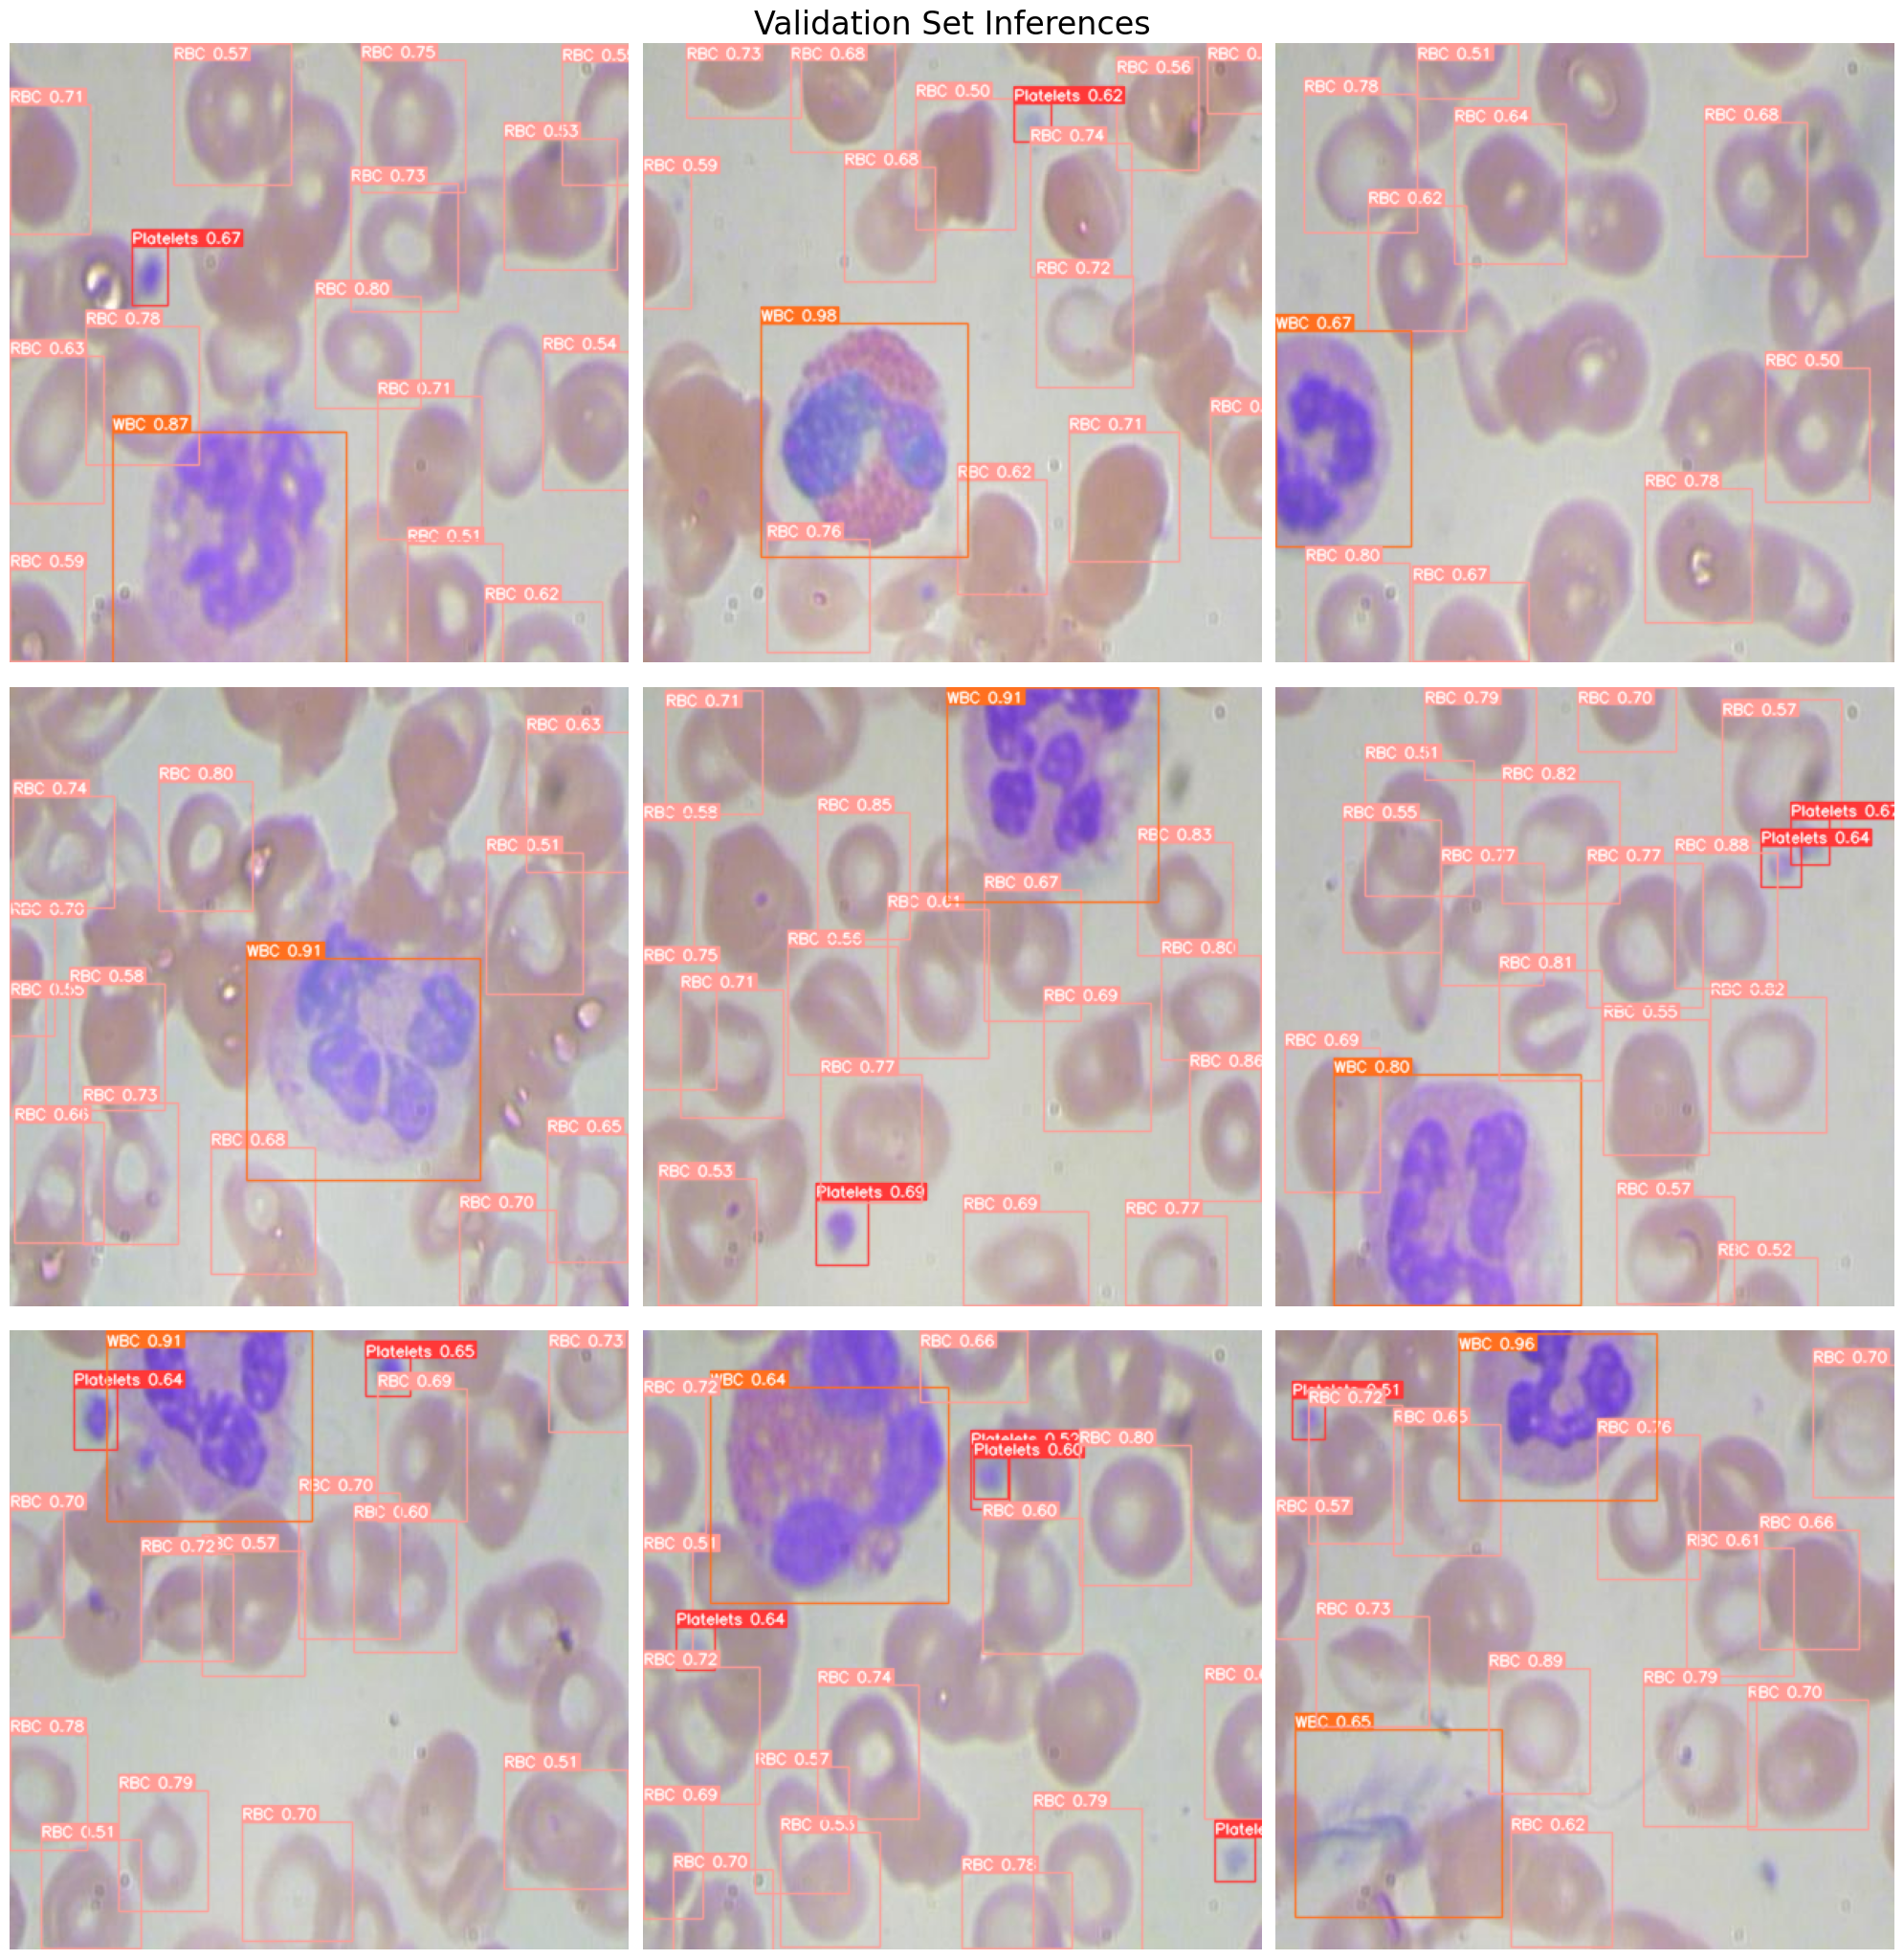

In [ ]:
valid_images_path = '/content/drive/MyDrive/ML in Medicine/Final/valid/images'

# List all jpg images in the directory
image_files = [file for file in os.listdir(valid_images_path) if file.endswith('.jpg')]

# Select 9 images at equal intervals
num_images = len(image_files)
selected_images = [image_files[i] for i in range(0, num_images, num_images // 9)]

# Initialize the subplot
fig, axes = plt.subplots(3, 3, figsize=(20, 21))
fig.suptitle('Validation Set Inferences', fontsize=24)

# Perform inference on each selected image and display it
for i, ax in enumerate(axes.flatten()):
    image_path = os.path.join(valid_images_path, selected_images[i])
    results = best_model.predict(source=image_path, imgsz=640, conf=0.5)
    annotated_image = results[0].plot(line_width=1)
    annotated_image_rgb = cv2.cvtColor(annotated_image, cv2.COLOR_BGR2RGB)
    ax.imshow(annotated_image_rgb)
    ax.axis('off')

plt.tight_layout()
plt.show()


image 1/1 /content/drive/MyDrive/ML in Medicine/Final/test/images/BloodImage_00112_jpg.rf.978cec39235980055c2ad7ff8b6f1912.jpg: 640x640 7 RBCs, 1 WBC, 95.0ms
Speed: 3.0ms preprocess, 95.0ms inference, 1.8ms postprocess per image at shape (1, 3, 640, 640)


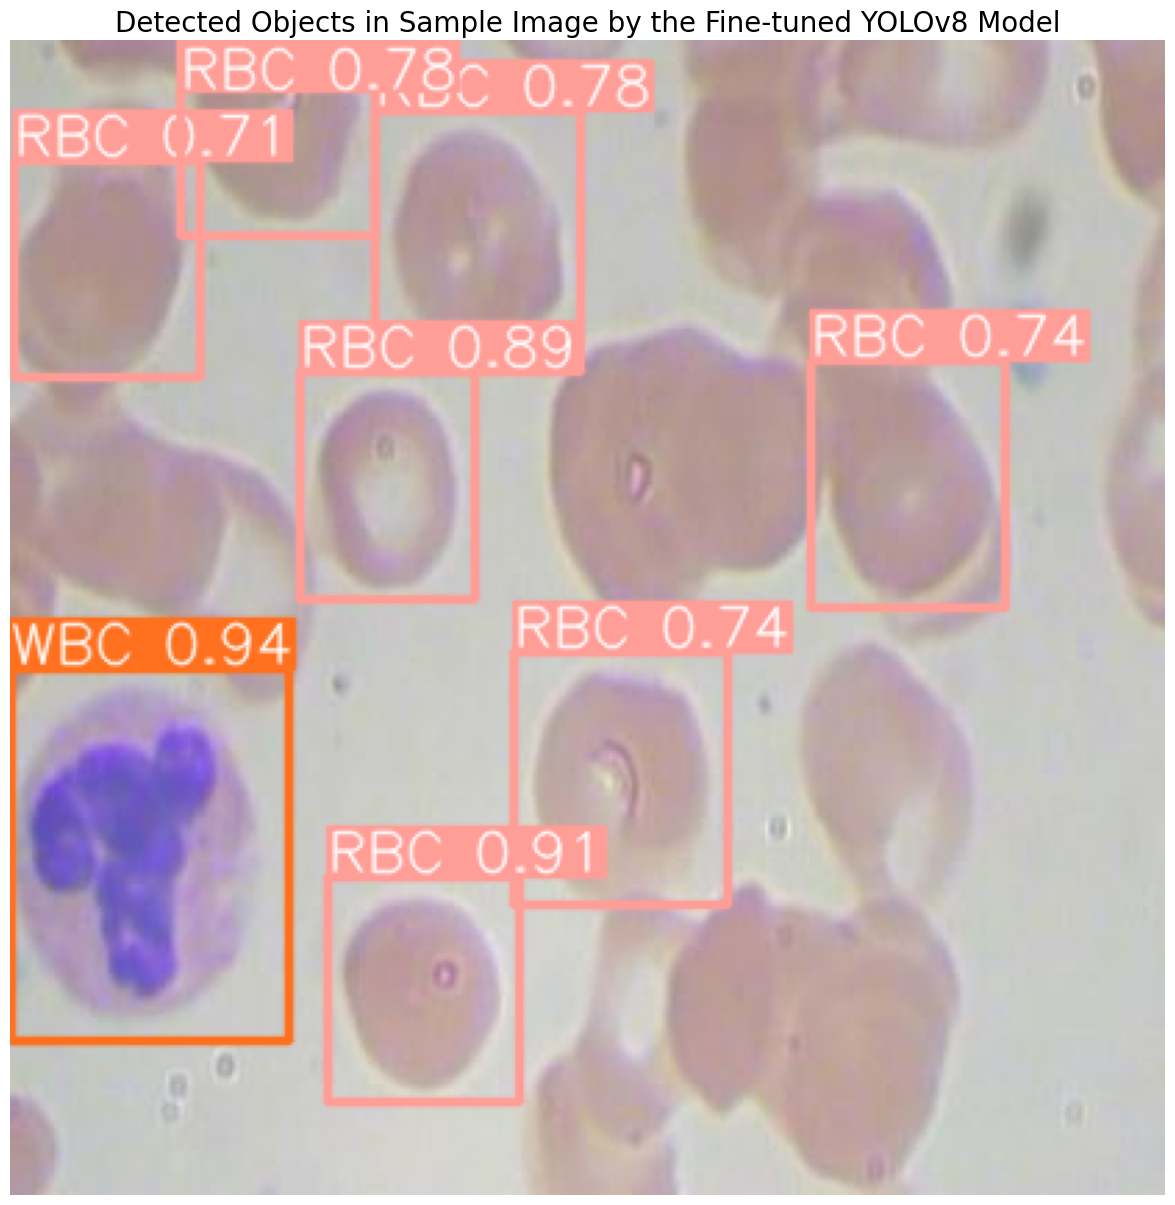

In [ ]:
sample_image_path = '/content/drive/MyDrive/ML in Medicine/Final/test/images/BloodImage_00112_jpg.rf.978cec39235980055c2ad7ff8b6f1912.jpg'

# Perform inference on the provided image using best model
results = best_model.predict(source=sample_image_path, imgsz=640, conf=0.7)

# Annotate and convert image to numpy array
sample_image = results[0].plot(line_width=2)

# Convert the color of the image from BGR to RGB for correct color representation in matplotlib
sample_image = cv2.cvtColor(sample_image, cv2.COLOR_BGR2RGB)

# Display annotated image
plt.figure(figsize=(20,15))
plt.imshow(sample_image)
plt.title('Detected Objects in Sample Image by the Fine-tuned YOLOv8 Model', fontsize=20)
plt.axis('off')
plt.show()

In [ ]:
import shutil

# Zip the folder
shutil.make_archive("/content/runs", 'zip', "/content/runs", ".")

# Download the zip file
from google.colab import files
files.download("/content/runs.zip")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
selected_image_files = '/content/drive/MyDrive/ML in Medicine/Final/test/images/BloodImage_00112_jpg.rf.978cec39235980055c2ad7ff8b6f1912.jpg

for selected_image_file in selected_image_files:
    demo_image = selected_image_file
    # Get the corresponding label file
    demo_label = pathlib.Path(labels_dir) / f"{selected_image_file.stem}.txt"

    # Load the image using OpenCV's imread function
    image = cv2.imread(str(demo_image))

    # Get the list of class names from the 'data' dictionary
    class_list = data_yaml['names']

    # Define a list of colors to be used to draw bounding boxes
    colors = [(255, 0, 0), (0, 255, 0), (0, 0, 255)]

    # Get the height and width of the image
    height, width, _ = image.shape

    # Create an empty list T
    T = []

    # Open the label file 'demo_label' in read mode and process each line
    with open(demo_label, "r") as file1:
        for line in file1.readlines():
            # Split the line into a list of strings
            split = line.split(" ")

            # Get the class id from the first element of the split list
            class_id = int(split[0])

            # Get the color corresponding to the class id from the 'colors' list
            color = colors[class_id]
            clazz = class_list[class_id]

            # Get the x, y, w, h bounding box coordinates from the split list
            x, y, w, h = float(split[1]), float(split[2]), float(split[3]), float(split[4])

            # Rescale the x, y, w, h values to the size of the image
            box = [int((x - 0.5*w)* width), int((y - 0.5*h) * height), int(w*width), int(h*height)]

            # Draw a rectangle on the image using the 'box' and 'color' values
            cv2.rectangle(image, box, color, 2)

            # Draw a filled rectangle for the class label on the image
            cv2.rectangle(image, (box[0], box[1] - 20), (box[0] + box[2], box[1]), color, -1)

            # Write the class label on the image
            cv2.putText(image, class_list[class_id], (box[0], box[1] - 5), cv2.FONT_HERSHEY_SIMPLEX, .5, (0,0,0))

        # Show the image using matplotlib
        plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
        # Optionally resize the image (commented out in code)
        image = cv2.resize(image, (600, 600))
        plt.show()

SyntaxError: unterminated string literal (detected at line 1) (<ipython-input-7-fdef14189f4c>, line 1)

In [ ]:
image_files = [f for f in pathlib.Path(images_dir).iterdir() if f.is_file()]
colors = [(255, 0, 0), (0, 255, 0), (0, 0, 255)]
class_list = data_yaml['names']


0: 416x416 1 Platelets, 13 RBCs, 1 WBC, 70.4ms
1: 416x416 8 Plateletss, 20 RBCs, 1 WBC, 70.4ms
Speed: 1.1ms preprocess, 70.4ms inference, 1.7ms postprocess per image at shape (1, 3, 416, 416)


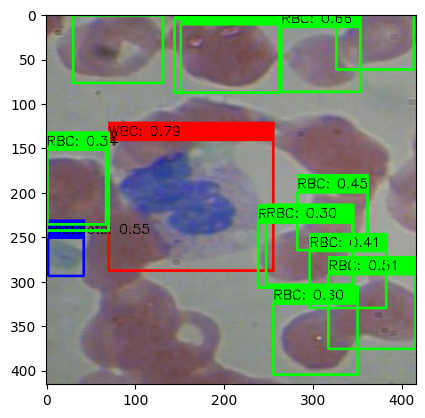

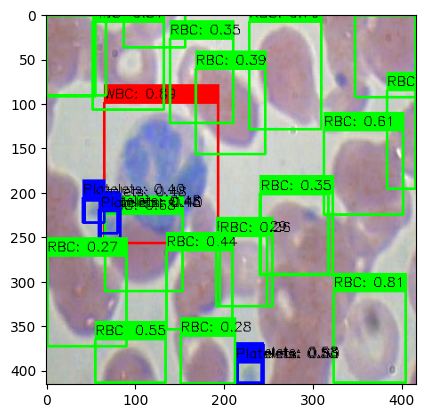

In [ ]:
def test_inference(model):
    selected_image_files = image_files[:2]
    results = model(selected_image_files)
    i = 0
    for result in results:
        boxes = result.boxes  # Boxes object for bbox outputs
        masks = result.masks  # Masks object for segmentation masks outputs
        keypoints = result.keypoints  # Keypoints object for pose outputs
        probs = result.probs  # Probs object for classification outputs

        image_file = selected_image_files[i]
        i = i + 1
        image = cv2.imread(str(image_file))

        for b in boxes:
            xywh = b.xywh
            x = int(xywh[0][0].item())
            y = int(xywh[0][1].item())
            w = int(xywh[0][2].item())
            h = int(xywh[0][3].item())
            conf = b.conf.item()

            class_id = int(b.cls.item())
            color = colors[class_id]
            clazz = class_list[class_id]

            w2 = int(w/2)
            h2 = int(h/2)
            box = [x-w2,y-h2,w,h]
            # Rescale the x, y, w, h values to the size of the image
            #box = [int((x - 0.5*w)* width), int((y - 0.5*h) * height), int(w*width), int(h*height)]


            # Draw a rectangle on the image using the 'box' and 'color' values
            cv2.rectangle(image, box, color, 2)

            # Draw a filled rectangle for the class label on the image
            cv2.rectangle(image, (box[0], box[1] - 20), (box[0] + box[2], box[1]), color, -1)

            # Write the class label on the image
            cap = f'{clazz}: {conf:.2f}'
            cv2.putText(image, cap, (box[0], box[1] - 5), cv2.FONT_HERSHEY_SIMPLEX, .5, (0,0,0))


        # Show the image using matplotlib
        plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
        # Optionally resize the image (commented out in code)
        #image = cv2.resize(image, (600, 600))
        plt.show()

test_inference(baseline_model)


In [ ]:
model=YOLO('/content/drive/MyDrive/ML in Medicine/runs/detect/train/weights/best.pt')

In [ ]:
image_path='/content/drive/MyDrive/ML in Medicine/Final/test/images/BloodImage_00265_jpg.rf.7d102d5f38caddb90a465912fb7bdc5c.jpg'

array([[[173, 179, 178],
        [174, 180, 179],
        [175, 182, 179],
        ...,
        [198, 193, 190],
        [194, 193, 189],
        [191, 192, 188]],

       [[172, 178, 177],
        [173, 179, 178],
        [175, 182, 179],
        ...,
        [198, 193, 190],
        [194, 193, 189],
        [191, 192, 188]],

       [[171, 176, 175],
        [173, 178, 177],
        [175, 180, 178],
        ...,
        [197, 194, 190],
        [192, 193, 189],
        [188, 192, 187]],

       ...,

       [[196, 189, 196],
        [200, 193, 200],
        [205, 197, 207],
        ...,
        [185, 152, 179],
        [194, 149, 182],
        [198, 148, 182]],

       [[193, 184, 194],
        [197, 188, 198],
        [202, 194, 204],
        ...,
        [185, 152, 179],
        [194, 149, 182],
        [199, 148, 182]],

       [[189, 180, 190],
        [194, 185, 195],
        [199, 191, 201],
        ...,
        [186, 153, 180],
        [196, 149, 182],
        [199, 148, 182]]], dtype=uint8)
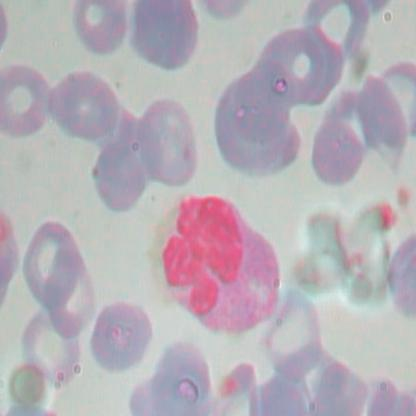

In [ ]:
image=cv2.imread(image_path)
image

In [ ]:
result=model(image,show=True,save=True)


WARNING ⚠️ Environment does not support cv2.imshow() or PIL Image.show()


0: 416x416 2 Plateletss, 21 RBCs, 1 WBC, 3793.4ms
Speed: 1.8ms preprocess, 3793.4ms inference, 2.0ms postprocess per image at shape (1, 3, 416, 416)
Results saved to runs/detect/predict2


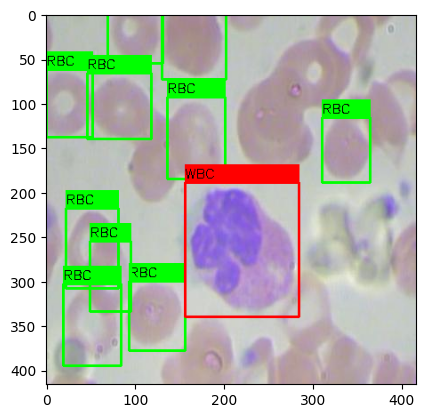

In [ ]:
import pathlib
import random
import cv2
import matplotlib.pyplot as plt

# Define the directory paths for images and labels
images_dir_test = '/content/drive/MyDrive/ML in Medicine/Final/test/images/BloodImage_00265_jpg.rf.7d102d5f38caddb90a465912fb7bdc5c.jpg'
labels_dir_test = '/content/drive/MyDrive/ML in Medicine/Final/test/labels/BloodImage_00265_jpg.rf.7d102d5f38caddb90a465912fb7bdc5c.txt'

# Load the image using OpenCV's imread function
image = cv2.imread(images_dir_test)

# Get the list of class names from the 'data' dictionary
class_list = data_yaml['names']

# Define a list of colors to be used to draw bounding boxes
colors = [(255, 0, 0), (0, 255, 0), (0, 0, 255)]

# Get the height and width of the image
height, width, _ = image.shape

# Open the label file 'demo_label' in read mode and process each line
with open(labels_dir_test, "r") as file1:
    for line in file1.readlines():
        # Split the line into a list of strings
        split = line.split(" ")

        # Get the class id from the first element of the split list
        class_id = int(split[0])

        # Get the color corresponding to the class id from the 'colors' list
        color = colors[class_id]
        clazz = class_list[class_id]

        # Get the x, y, w, h bounding box coordinates from the split list
        x, y, w, h = float(split[1]), float(split[2]), float(split[3]), float(split[4])

        # Rescale the x, y, w, h values to the size of the image
        box = [int((x - 0.5 * w) * width), int((y - 0.5 * h) * height), int(w * width), int(h * height)]

        # Draw a rectangle on the image using the 'box' and 'color' values
        cv2.rectangle(image, (box[0], box[1]), (box[0] + box[2], box[1] + box[3]), color, 2)

        # Draw a filled rectangle for the class label on the image
        cv2.rectangle(image, (box[0], box[1] - 20), (box[0] + box[2], box[1]), color, -1)

        # Write the class label on the image
        cv2.putText(image, class_list[class_id], (box[0], box[1] - 5), cv2.FONT_HERSHEY_SIMPLEX, .5, (0, 0, 0))

# Show the image using matplotlib
plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
# Optionally resize the image (commented out in code)
# image = cv2.resize(image, (600, 600))
plt.show()
